In [165]:
# add parent directory to path: enable import from parent dir
import sys
sys.path.append('../')

import io
import math
import PIL

from gym import Env as OpenAIEnv
from gym import spaces
from IPython.display import HTML
from IPython.display import Video
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
import numpy as np

## Grid World - Maze

In [202]:
from gym import Env as OpenAIEnv
from gym import spaces
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
import numpy as np

class Rewards:
    GOAL = 5.0
    WALL = -15.0
    OUT_OF_BOUND = -0.75
    VISITED = -0.85
    LEGAL = -0.05

class GridEnv(OpenAIEnv):
    def __init__(
        self,
        maze,
        is_stochastic,
        action_transitions,
        max_timesteps=300,
        state_as_img=False,
        full_state=False,
    ):
        self.maze = maze
        self.w, self.h = np.shape(maze)
        self.is_stochastic = is_stochastic
        self.n_actions = len(action_transitions)
        self.action_transitions = action_transitions
        self.current_action = None
        self.observation_space = spaces.Discrete(self.w*self.h)
        self.action_space = spaces.Discrete(self.n_actions)
        self.states = [(i, j) for j in range(self.w) for i in range(self.h)]
        self.actions = list(self.action_transitions)
        self.max_timesteps = max_timesteps
        self.timestep = 0
        self.state = maze.copy()
        self.visited = {(i, j):False for j in range(self.w) for i in range(self.h)}
        self.agent_pos = np.array([0, 0])
        self.current_state = (self.agent_pos[0], self.agent_pos[1])
        self.max_timesteps = max_timesteps
        self.state_as_img = state_as_img
        self.max_reward = Rewards.GOAL
        self.min_reward = Rewards.WALL
        self.full_state = full_state
        
        # set random goal position
        self.goal_pos = np.array([self.w-1, self.h-1])
        
        # set colors for visualization
        self.state[self.agent_pos[0]][self.agent_pos[1]] = 0.2
        self.state[self.goal_pos[0]][self.goal_pos[1]] = 0.4
        
        fig, ax, mesh = self._set_figure(
            self.state,
            show_fig=True,
        )
        
    @staticmethod
    def _get_plot_img(fig):
        fig.canvas.draw()
        return PIL.Image.frombytes(
            'RGB',
            fig.canvas.get_width_height(),
            fig.canvas.tostring_rgb(),
        )
        
    def _set_figure(
        self,
        grid,
        n=1,
        m=1,
        figsize=(5, 5),
        show_fig=False,
        show_title=False,
    ):
        fig, ax = plt.subplots(n, m, figsize=figsize)
        mesh = []
        
        # for single plot
        if n == 1 and m == 1:
            # Set grid size
            ax.set_xticks(np.arange(0, self.w, 1))
            ax.set_yticks(np.arange(0, self.h, 1))
            mesh.append(ax.pcolormesh(grid, cmap ='tab20c'))
            plt.grid()
        else:
            for i in range(n):
                for j in range(m):
                    ax[i][j].set_xticks(np.arange(0, self.w, 1))
                    ax[i][j].set_yticks(np.arange(0, self.h, 1))
                    mesh.append(ax[i][j].pcolormesh(grid, cmap ='tab20c'))
                    ax[i][j].grid()
        
        if show_title:
            plt.title(
                f'#states: {self.observation_space.n}, #actions: {self.n_actions}',
                y=-0.01,
                color='gray',
            )
        
        if not show_fig:
            plt.close(fig)
        
        return fig, ax, mesh
    
    def _move_agent(self, x, y):
        goal_achieved = False
        # reward when the agent doesnt end up in goal state
        reward = Rewards.LEGAL
        
        if self.state[self.agent_pos[0]][self.agent_pos[1]] == 0.65:
            self.state[self.agent_pos[0]][self.agent_pos[1]] = 0.0
        
        # check if the current agent position is a wall or goal state
        if self.state[self.agent_pos[0]][self.agent_pos[1]] != 0.0 and \
         self.state[self.agent_pos[0]][self.agent_pos[1]] != 0.4:
            # set different color to visited position
            self.state[self.agent_pos[0]][self.agent_pos[1]] = 0.35
            
        
        # clip out-of-bound positions to the edges
        if x >= self.h:
            # reward when the agent goes out of bound
            reward = Rewards.OUT_OF_BOUND
            x = self.h-1
        else:
            x = max(0, x)
            
        if y >= self.w:
            # reward when the agent goes out of bound
            reward = Rewards.OUT_OF_BOUND
            y = self.w-1
        else:
            y = max(0, y)
        
        # set new position
        self.agent_pos[0], self.agent_pos[1] = x, y
        
        # check if the agent's new position is a wall
        if self.state[x][y] == 0.0:
            self.state[x][y] = 0.65
            # reward when the agent hits the wall
            reward = Rewards.WALL
        else:   
            # set agent color in the visualisation
            self.state[x][y] = 0.2
            
        
        if self.visited[(x, y)]:
            # reward when the agent is traverses the visited states
            reward = min(Rewards.VISITED, reward)
        
        
        if (self.agent_pos == self.goal_pos).all():
            goal_achieved = True
            # reward when the agent reaches goal state
            reward = Rewards.GOAL
            
        return reward, goal_achieved
        

    def _render_plots(self, n, m, figsize):
        fig, ax, mesh = self._set_figure(
            self.state,
            n,
            m,
            figsize, 
            show_fig=True,
        )
        count = 0
        for i in range(n):
            for j in range(m):
                self._update_fig(_, mesh[count], ax[i][j])
                count += 1
        
        plt.show()
        
    
    def _update_fig(self, i, mesh, ax, action_seq=None):
        action = action_seq[i] if action_seq else None
        action, reward, _, _, _ = self.step(action=action)
        self.state[self.goal_pos[0]][self.goal_pos[1]] = 0.4
        mesh.set_array(self.state.flatten())
        ax.set_title(
            f'timestep: {self.timestep} | reward: {reward} | action: {action}')
        return mesh
    
    def _perform_action(self, action):
        self.current_action = action
        can_agent_move = True
        goal_achieved = False
        
        if self.is_stochastic:
            # make a move according to the transition probability                 
            can_agent_move = np.random.choice(
                [True, False], p=[
                    self.action_transitions[action],
                    1-self.action_transitions[action],
                ],
            )
            if can_agent_move == False:
                reward = Rewards.LEGAL
                
        if can_agent_move:
            if action.lower() == 'w':
                reward, goal_achieved = self._move_agent(
                    self.agent_pos[0]+1, self.agent_pos[1]
                )
            elif action.lower() == 's':
                reward, goal_achieved = self._move_agent(
                    self.agent_pos[0]-1, self.agent_pos[1]
                )
            elif action.lower() == 'a':
                reward, goal_achieved = self._move_agent(
                    self.agent_pos[0], self.agent_pos[1]-1
                )
            elif action.lower() == 'd':
                reward, goal_achieved = self._move_agent(
                    self.agent_pos[0], self.agent_pos[1]+1
                )

        return reward, goal_achieved
        
    def reset(self):
        self.state = self.maze.copy()
        self.timestep = 0
        self.goal_pos = np.array([self.w-1, self.h-1])
        self.agent_pos = np.array([0, 0])
        
        # set colors for visualization
        self.state[self.agent_pos[0]][self.agent_pos[1]] = 0.2
        self.state[self.goal_pos[0]][self.goal_pos[1]] = 0.4
        
        self.current_state = (self.agent_pos[0], self.agent_pos[1])
        self.visited = {(i, j):False for j in range(self.w) for i in range(self.h)}
        
        if self.state_as_img:
            fig, _, _ = self._set_figure(self.state)
            curr_state = self._get_plot_img(fig)
        elif self.full_state:
            curr_state = self.state.flatten()
        else:
            curr_state = self.current_state
        
        return curr_state
    
    def step(self, action=None):
        done = False
        if not action:
            # select random action if no action is provided
            action_idx = np.random.choice(self.action_space.n)
            action = self.actions[action_idx]
        elif action not in self.actions:
            raise Exception('Action not defined for current environment')
        
        reward, goal_achieved = self._perform_action(action)
                                                                   
        self.timestep += 1
        self.current_state = (self.agent_pos[0], self.agent_pos[1])
        self.visited[(self.agent_pos[0],self.agent_pos[1])] = True
        
        if self.max_timesteps:
            if self.timestep >= self.max_timesteps:
                done = True
                
        if goal_achieved:
            done = True
            
        if self.state_as_img:
            fig, _, _ = self._set_figure(self.state)
            curr_state = self._get_plot_img(fig)
        elif self.full_state:
            curr_state = self.state.flatten()
        else:
            curr_state = self.current_state
                                                                   
        return action, reward, goal_achieved, curr_state, done
    
    def render(self, show=False):
        fig, ax, mesh = self._set_figure(
            self.state,
            show_fig=True,
        )
        if show:
            plt.show()
        
    def animate(self, action_seq=None, filename='animation.mp4'):
        self.reset()
        fig, ax, mesh = self._set_figure(self.state)
        ani = FuncAnimation(
            fig,
            self._update_fig,
            init_func=(lambda: None),
            frames=len(action_seq) if action_seq else self.max_timesteps,
            interval=160,
            fargs=(mesh[0], ax, action_seq, ), 
        )
        ani.save(filename)
        return ani

## Deterministic Environment

In [4]:
simple_maze = np.array([
    [ 1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  0.],
    [ 0.,  0.,  1.,  1.],
    [ 1.,  0.,  1.,  0.],
])

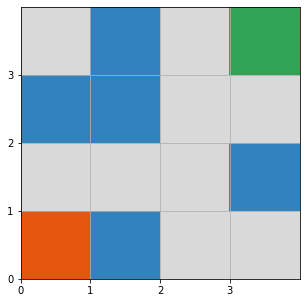

In [203]:
deterministic_env = GridEnv(
    maze=simple_maze.copy(),
    is_stochastic=False,
    action_transitions={
        'w': 1,
        's': 1,
        'd': 1,
        'a': 1,
    },
    state_as_img=True,
)

### Render #n timesteps

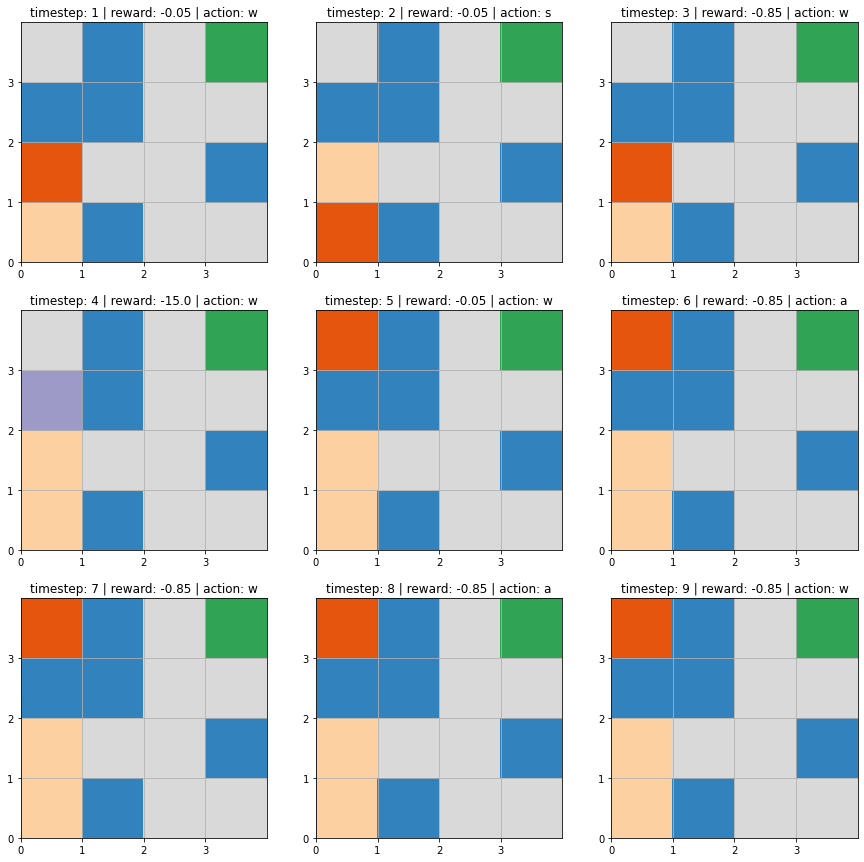

In [146]:
deterministic_env._render_plots(3, 3, figsize=(15, 15))

### Render grid manually

Action: s, Goal Achieved: False, Reward: -15.0, State: (2, 0)


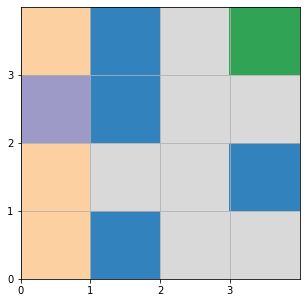

In [147]:
# random action will be selected if no action is passed to the step function
action, reward, goal_achieved, state, _ = deterministic_env.step(action='s')
deterministic_env.render()
print(f'Action: {action}, Goal Achieved: {goal_achieved}, Reward: {reward}, State: {state}')

### Animation

In [148]:
deterministic_env.animate(
    filename='deterministic_animation.mp4',
    action_seq=['w', 'd', 'd', 'w', 'w', 'd'],
)
Video('deterministic_animation.mp4')

## Stochastic Environment

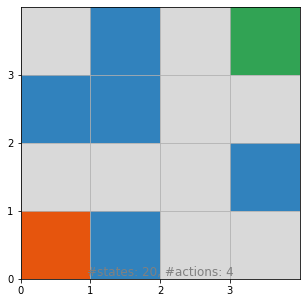

In [401]:
stochastic_env = GridEnv(
    maze = simple_maze.copy(),
    is_stochastic=True,
    action_transitions={
        'w': 0.95,
        's': 0.98,
        'd': 0.96,
        'a': 0.99,
    }
)

### Render #n timesteps

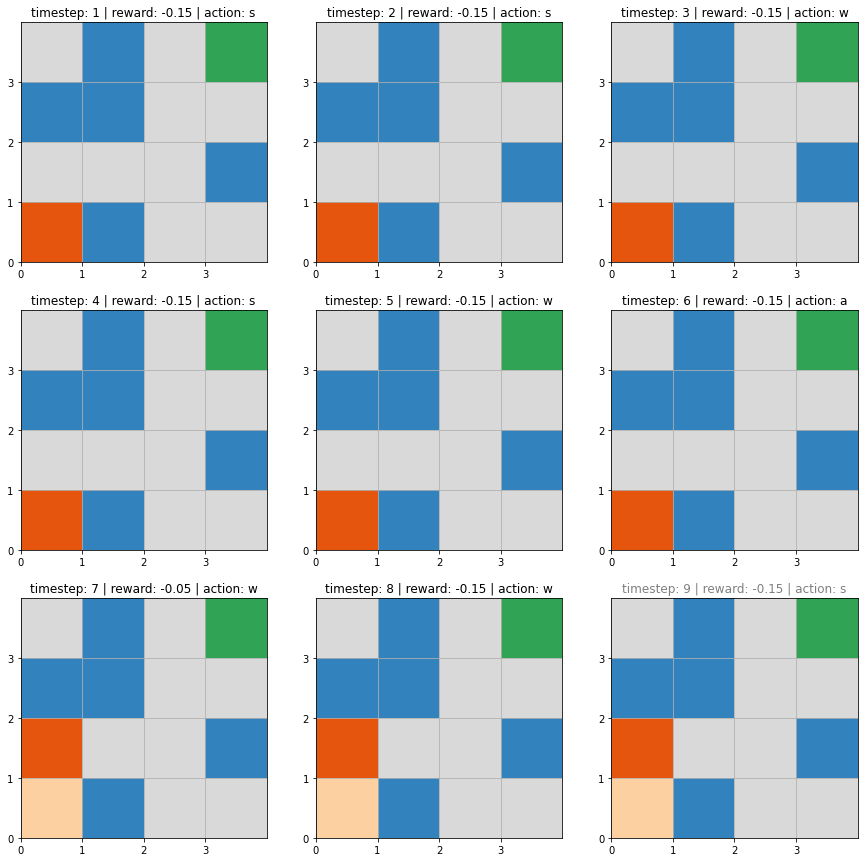

In [402]:
stochastic_env._render_plots(3, 3, figsize=(15, 15))

### Render #n steps manually

Action: w, Goal Achieved: False, Reward: -0.15, State: (2, 0)


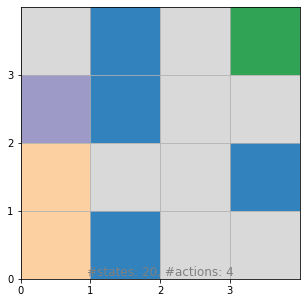

In [414]:
# random action will be selected if no action is passed to the step function
action, reward, goal_achieved, state, _ = stochastic_env.step(action='w')
stochastic_env.render()
print(f'Action: {action}, Goal Achieved: {goal_achieved}, Reward: {reward}, State: {state}')

### Animation

In [416]:
stochastic_env.animate('stochastic_animation.mp4')
Video('stochastic_animation.mp4')